In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import numpy as np
import torch.utils.data as utils
from torch.utils.data import DataLoader
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score
from torch.utils.data import Subset
from torchvision import  transforms
import pickle as pkl
from os.path import join as oj
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import argparse
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
from tqdm import tqdm
sys.path.append('../fit/')
import cd
import sys
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
from copy import deepcopy
import pandas as pd
import seaborn as sns
sns.set()
import torch.nn.functional as F
from os.path import join as oj
pd.set_option('precision', 2)
%matplotlib inline

In [4]:
save_path = "../../results_for_export"
trained_model_folder = '../skin_cancer/feature_models_gradient/'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder) if 'pkl'  in fname]) 
# other models were trained badly

results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects() 


In [5]:
len(results)

5

In [6]:
results['final_acc'] = [max(x) for x in results['val_acc_history']] #TODO change so it 
results['final_acc_train'] = [max(x)  for x in results['train_acc_history']]
results['AUC (no patches)'] =[0 for x in results['regularizer_rate']]
results['final_cd'] = [min(x) for x in results['train_cd_history']]
results['final_test_loss'] = [min(x) for x in results['val_loss_history']]
results['final_train_loss'] = [min(x) for x in results['train_loss_history']]
results['F1 score (no patches)'] =[0 for x in results['regularizer_rate']]


# results['regularizer_rate'][6] =-1
# results = results.dropna()
# results = results[results.learning_rate ==0.01]
# results = results[results.momentum ==0.9]
# results = results[results.batch_size ==16]
# results = results[results.regularizer_rate !=5]

In [7]:
len(results)

5

In [8]:
latex_table = results[['regularizer_rate',
                       'final_acc', 
                       'AUC (no patches)',
                       'F1 score (no patches)',]].groupby(['regularizer_rate',]).max()
#                        'AUC (patches)',
#                        'F1 score (patches)'

In [10]:
results[['regularizer_rate',
                       'final_acc', 
                       'pid',
                       'F1 score (no patches)',]].groupby(['regularizer_rate',]).mean()
#                        'AUC (patches)',
#                        'F1 score (patches)'

,final_acc,F1 score (no patches)
regularizer_rate,,
0.0,0.89,0
0.1,0.88,0
1.0,0.89,0
10.0,0.89,0


In [11]:
results[['regularizer_rate',
                       'final_acc', 
                       'pid',
                       'F1 score (no patches)',]]
#                        'AUC (patches)',
#                        'F1 score (patches)', 'pid']]

,regularizer_rate,final_acc,pid,F1 score (no patches)
0,0.1,0.89,04811065276842002842,0
1,1.0,0.89,17384780265261436248,0
2,10.0,0.89,55417423080207755015,0
3,0.1,0.88,62508775403417245407,0
4,0.0,0.89,71855500153100424103,0


In [12]:
latex_table

,final_acc,AUC (no patches),F1 score (no patches)
regularizer_rate,,,
0.0,0.89,0,0
0.1,0.89,0,0
1.0,0.89,0,0
10.0,0.89,0,0


# Calculate ROC AUC

In [13]:
data_path = "../../../datasets"
save_path = oj(data_path, "ISIC_features")
from torch.utils.data import TensorDataset, ConcatDataset
with open(oj(save_path, "cancer.npy"), 'rb') as f:
    cancer_featuress = np.load(f)
with open(oj(save_path, "not_cancer.npy"), 'rb') as f:
    not_cancer_featuress = np.load(f)
    
cancer_targets = np.ones((cancer_featuress.shape[0])).astype(np.int64)
not_cancer_targets = np.zeros((not_cancer_featuress.shape[0])).astype(np.int64)
with open(oj(save_path, "not_cancer_cd.npy"), 'rb') as f:
    not_cancer_cd= np.load(f)
not_cancer_dataset = TensorDataset(torch.from_numpy(not_cancer_featuress).float(), torch.from_numpy(not_cancer_targets),torch.from_numpy(not_cancer_cd).float())

cancer_dataset = TensorDataset(torch.from_numpy(cancer_featuress).float(), torch.from_numpy(cancer_targets),torch.from_numpy(-np.ones((len(cancer_featuress), 2, 25088))).float())
complete_dataset = ConcatDataset((cancer_dataset, not_cancer_dataset))



num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(complete_dataset, [num_train, num_test, num_val])


datasets = {'train' : train_dataset, 'test':test_dataset, 'val': val_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset), 'val': len(val_dataset)}

In [ ]:
val_filtered_dataset = torch.utils.data.Subset(complete_dataset, [idx for idx in test_dataset.indices if complete_dataset[idx][2][0,0] ==-1])

In [ ]:
device = torch.device(0)
model = models.vgg16(pretrained=True)
# make conv untrainable - test if needed
model.classifier[-1] = nn.Linear(4096, 2)
model = model.classifier.to(device)

In [ ]:
def eval_model_on(model, dataset):
    val_filtered_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=True, num_workers=4)
    model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels, cd in val_filtered_dataloader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,0].detach().cpu().numpy())
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return 1-y, y_hat


In [ ]:
results_for_auc = results[['regularizer_rate','pid',]]
roc_curves = {}
f1_scores_pid = {}
auc_scores = {}
f1_scores = {}
auc_scorespid = {}

for index, row in results_for_auc.iterrows():

    with open(oj(trained_model_folder, str(row['pid']) + '.pt'), 'rb') as f:

        weights = torch.load(f)
    model.load_state_dict(weights)
    y, y_hat = eval_model_on(model, val_filtered_dataset)

    precision, recall, _ = roc_curve(y_hat, y)

    roc_curves[row['regularizer_rate']] = (precision, recall)
    auc_scores[row['regularizer_rate']] = roc_auc_score(y_hat, y)
    f1_scores[row['regularizer_rate']] = f1_score(y_hat, y > .8)
    auc_scorespid[row['pid']] = roc_auc_score(y_hat, y)
    f1_scores_pid[row['pid']] = f1_score(y_hat, y > .8)

results['AUC (no patches)'] =[auc_scorespid[x] for x in results['pid']]
results['F1 score (no patches)'] =[f1_scores_pid[x] for x in results['pid']]

In [ ]:
results_for_auc = results[['regularizer_rate','pid',]]
roc_curves = {}
f1_scores_pid = {}
auc_scores = {}

auc_scorespid = {}

for index, row in results_for_auc.iterrows():

    with open(oj(trained_model_folder, str(row['pid']) + '.pt'), 'rb') as f:

        weights = torch.load(f)
    model.load_state_dict(weights)
    y, y_hat = eval_model_on(model, test_dataset)

    precision, recall, _ = roc_curve(y_hat, y)

    roc_curves[row['regularizer_rate']] = (precision, recall)
    auc_scores[row['regularizer_rate']] = roc_auc_score(y_hat, y)
    f1_scores[row['regularizer_rate']] = f1_score(y_hat, y > .8)
    auc_scorespid[row['pid']] = roc_auc_score(y_hat, y)
    f1_scores_pid[row['pid']] = f1_score(y_hat, y > .8)

results['AUC (patches)'] =[auc_scorespid[x] for x in results['pid']]
results['F1 score (patches)'] =[f1_scores_pid[x] for x in results['pid']]

sns.set()
fig, ax = plt.subplots(figsize = (10,10))

for key in roc_curves.keys():
    key_label = key
    if key == 10.0 or key == 0.0 or key == -1:
        if key ==-1:
            key_label  = "Excluded patches"

        ax.plot(roc_curves[key][1], 1-roc_curves[key][0], label = str(key_label) + " AUC: "+ "{:2.2f}".format(auc_scores[key]))
ax.set_ylabel("Specificity");
ax.set_xlabel("Sensitivity");
fig.legend(loc=10)
fig.suptitle("Malignant tumor classification on filtered validation set")
save_path = "../results_for_export"
fig.savefig(oj(save_path, "with_reg"))

# Find failures

In [76]:

import torchvision.models as models
from PIL import Image
device = torch.device("cuda")
model_no_reg = models.vgg16(pretrained=True)
model_no_reg.classifier[-1] = nn.Linear(4096, 2)
model_no_reg = model_no_reg.eval()
model_no_reg.classifier.load_state_dict(torch.load('../skin_cancer/feature_models/03003534103033476204.pt'))
model_reg = models.vgg16(pretrained=True)
model_reg.classifier[-1] = nn.Linear(4096, 2)
model_reg = model_reg.eval()
model_reg.classifier.load_state_dict(torch.load('../skin_cancer/feature_models/35353744220131105427.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
model_no_reg = model_no_reg.cuda()
model_reg = model_reg.cuda()

In [15]:
# load the two imgs
data_path = "../../../datasets/ISIC/raw_data/"
img_path_nocancer = oj(data_path, "not_cancer")
img_path_cancer = oj(data_path, "cancer")
seg_path  = oj(data_path, "../segmentation")
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

how do:
diffictulty: filter out the correct images for validation?
then afterwards it shouldn't be so difficult - 

In [16]:
from torchvision.transforms import ToTensor, Compose, Normalize
complete_dataset = torchvision.datasets.ImageFolder(data_path, transform=Compose([ToTensor(), Normalize(mean, std)]))
num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(complete_dataset, [num_train, num_test, num_val])
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16,
                                             shuffle=False, num_workers=4)

In [32]:
with torch.no_grad():
    correct = 0
    correct_noreg = 0
    my_list = []
    my_list_targets = []

    for inputs, target in val_dataloader:

        inputs = inputs.to(device)
        target = 1- target.to(device) #switched classes for the dataset
        out_reg = model_reg(inputs)
        out_noreg = model_no_reg(inputs)
        correct+= (out_reg.argmax(dim = 1) == target).sum().item()
        correct_noreg+= (out_noreg.argmax(dim = 1) == target).sum().item()
        example_idx = np.where(((out_reg.argmax(dim = 1) == target)*(out_noreg.argmax(dim = 1) != target)).cpu().numpy())[0]
        
        if len(example_idx) >0:
            for idx in example_idx:

                my_list.append(inputs[idx])
                my_list_targets.append(target[idx].item())

In [50]:
correct_noreg/len(val_dataset)

0.8175519630484989

In [49]:
correct/len(val_dataset)

0.8415704387990762

## Smoothgrad on images

In [36]:
sys.path.append("../../pytorch-cnn-visualizations/src")
from vanilla_backprop import VanillaBackprop
from smooth_grad import generate_smooth_grad
from tqdm import tqdm_notebook
from gradcam import GradCam
from integrated_gradients import IntegratedGradients

In [42]:
my_list_all = [val_dataset[i+20][0] for i in range(20) ]
my_list_targets_all = [1-val_dataset[i+20][1] for i in range(20) ]

In [99]:
model_reg = model_reg.cuda()
model_no_reg = model_no_reg.cuda()

In [106]:
reg_backprop = IntegratedGradients(model_reg)
noreg_backprop = IntegratedGradients(model_no_reg)

In [112]:
triples = []
for img, target in tqdm_notebook(zip(my_list_all[:10], my_list_targets_all[:10])):
    
    test_img = img[None, :].cuda()
    test_img.requires_grad = True
    img_np = img.cpu().numpy().transpose(1,2,0)*std[None, None, :] + mean[None, None, :]
    
#     reg_saliency = noreg_backprop.generate_gradients(test_img, target).sum(axis = 0)
#     vanilla_saliency = reg_backprop.generate_gradients(test_img, target).sum(axis = 0)
#     reg_saliency = np.clip(reg_saliency, 0, np.percentile(reg_saliency, 99))
#     vanilla_saliency = np.clip(vanilla_saliency, 0, np.percentile(vanilla_saliency, 99))
#     reg_saliency = noreg_backprop.generate_gradients(test_img, target).sum(axis = 0)
#     vanilla_saliency = noreg_backprop.generate_gradients(test_img, 1-target).sum(axis = 0)
    
    reg_saliency = np.abs(generate_smooth_grad(reg_backprop, test_img, target, 100, 0.3)).sum(axis = 0)
    vanilla_saliency = np.abs(generate_smooth_grad(noreg_backprop, test_img, target, 100, 0.3)).sum(axis = 0)
    reg_saliency = np.clip(reg_saliency, 0, np.percentile(reg_saliency, 99))
    vanilla_saliency = np.clip(vanilla_saliency, 0, np.percentile(vanilla_saliency, 99))
    triples.append((img_np, vanilla_saliency, reg_saliency, target))

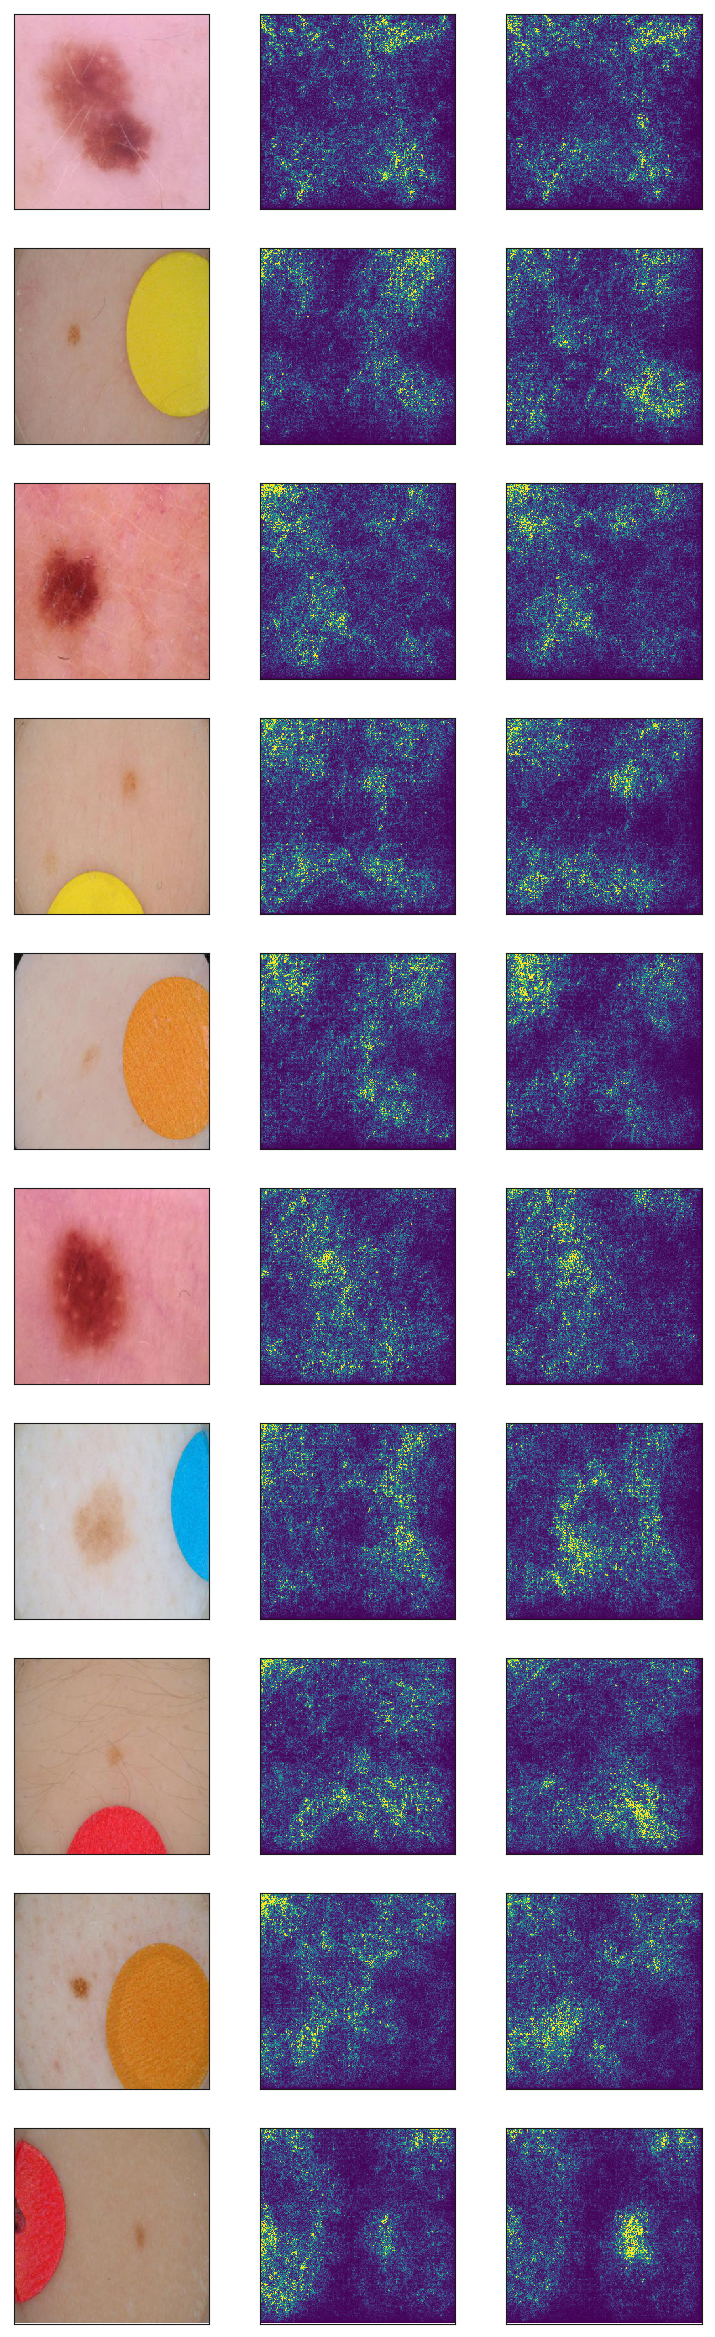

In [114]:
num_rows = 10
fig, axes = plt.subplots(ncols=3, nrows = num_rows, figsize=  (3*3, num_rows*3))
for i, (original_img, vanilla_sal, reg_sal, true_class) in enumerate(triples[:num_rows]):
    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow(reg_sal)
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,2].imshow(vanilla_sal)
    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)


# Add adversarial patches

In [ ]:
save_path = "../results_for_export"

In [ ]:
val_dataset[0][1]

In [ ]:
segmented_patches = []

my_img = val_dataset[0][0].cpu().numpy().swapaxes(2,0) * std +mean
my_segment = (my_img[:,:,2] < .3) 
segmented_patch = my_img *my_segment[:,:, None] 
segmented_patches.append((my_segment.copy(), segmented_patch.copy()))

my_img = val_dataset[5][0].cpu().numpy().swapaxes(2,0) * std +mean
my_segment = (my_img[:,:,2] < .3) * (my_img[:,:,0] > .8)
segmented_patch = my_img *my_segment[:,:, None] 
segmented_patches.append((my_segment.copy(), segmented_patch.copy()))

my_img = val_dataset[4][0].cpu().numpy().swapaxes(2,0) * std +mean
my_segment = (my_img[:,:,2] < .2) 
segmented_patch = my_img *my_segment[:,:, None] 
segmented_patches.append((my_segment.copy(), segmented_patch.copy()))

my_img = val_dataset[15][0].cpu().numpy().swapaxes(2,0) * std +mean
my_segment = (my_img[:,:,2] < .3) * (my_img[:,:,0] > .8)
segmented_patch = my_img *my_segment[:,:, None] 
segmented_patches.append((my_segment.copy(), segmented_patch.copy()))

In [ ]:
my_img = val_dataset[5][0].cpu().numpy().swapaxes(2,0) * std +mean
my_segment = (my_img[:,:,2] < .3) * (my_img[:,:,0] > .8)
segmented_patch = my_img *my_segment[:,:, None] 
my_img2 = val_dataset[20][0].cpu().numpy().swapaxes(2,0) * std +mean
my_img2[np.where(my_segment)] = my_img[np.where(my_segment)]
fig, axes = plt.subplots(ncols=3, figsize=  (15, 5))
axes[0].imshow(np.clip(my_img, 0, 1))
axes[0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
axes[1].imshow(np.clip(segmented_patch, 0, 1))
axes[1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
axes[2].imshow(np.clip(my_img2, 0, 1))
axes[2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

segmented_patch -= mean
segmented_patch/=std
segmented_patch_torch = torch.from_numpy(segmented_patch.swapaxes(0, 2).swapaxes(1, 2)).float()
is_patch = torch.from_numpy(my_segment)
fig.savefig(oj(save_path,"adversarial"))

In [ ]:
for my_segment, segmented_patch in segmented_patches:
    segmented_patch_torch = torch.from_numpy(segmented_patch.swapaxes(0, 2).swapaxes(1, 2)).float()

    y, y_hat = eval_model_on_adversarial(model_no_reg, test_dataset)
    
    sens = ((y > 0.5) == y_hat)[np.where(y_hat ==1)].mean()
    print(sens)
    
    

In [ ]:
0.35
0.27
0.23

In [ ]:
0.33
0.25
0.19

In [ ]:
77/3


In [ ]:
def eval_model_on_adversarial(model, dataset):
    val_filtered_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=True, num_workers=4)
    model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels in val_filtered_dataloader:
            inputs_new = torch.where(is_patch, segmented_patch_torch.float(), inputs)
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs_new.cuda()))[:,0].detach().cpu().numpy())
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return y, y_hat
